### import libs

In [3]:
import pandas as pd
from transformers import (
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    AutoTokenizer,
)
import torch

/scratch/cluster/piti/miniconda/envs/loading_models/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### set hyperparameters 

In [77]:
N_SAMPLES = 5 # no.of samples/trajectories
K = 9 #no. of vines for each sample to estimate MC return per token

### read csv file and create result df

In [78]:
thou_df = pd.read_csv("1000_prompt_res.csv", usecols=["prompt", "response"], nrows=N_SAMPLES)

In [79]:
result  = pd.DataFrame(columns=["MC_estimate_per_token", "tokenized_trajectory", "prompt_len", "response_len"])

### load tokenizer, value model and policy model

In [60]:
base_policy_id = "cleanrl/EleutherAI_pythia-1b-deduped__sft__tldr" 
reward_model_id = "cleanrl/EleutherAI_pythia-1b-deduped__reward__tldr"
trained_value_model_id = "Prathyusha101/lr_20k" 

In [61]:
reward_model = AutoModelForSequenceClassification.from_pretrained(reward_model_id)
trained_value_model = AutoModelForSequenceClassification.from_pretrained(trained_value_model_id)
policy = AutoModelForCausalLM.from_pretrained(base_policy_id)

In [62]:
tokenizer = AutoTokenizer.from_pretrained(base_policy_id)

### cuda stuff, setting device and loading models to gpu

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
reward_model.to(device)
trained_value_model.to(device)
policy.to(device)

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 2048)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-15): 16 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=2048, out_features=8192, bias=True)
          (dense_4h_to_h): Linear(in_features=8192, out_features=2048, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (final_layer_norm): LayerNorm((2048,), eps=1e-05, 

### tokenize trajectories, calculate len of prompt and response and add it to result df

In [81]:
def compute_token_lengths(row):
    # Tokenize prompt
    prompt_encoding = tokenizer(row['prompt'], return_tensors='pt', add_special_tokens=False)
    prompt_ids = prompt_encoding['input_ids'].squeeze(0)  # shape: [seq_len]

    # Tokenize response
    response_encoding = tokenizer(row['response'], return_tensors='pt', add_special_tokens=False)
    response_ids = response_encoding['input_ids'].squeeze(0)  # shape: [seq_len]

    return {
        'prompt_token_len': prompt_ids.shape[0],
        'response_token_len': response_ids.shape[0],
        'prompt': prompt_ids,    # torch.Tensor of shape [seq_len]
        'response': response_ids # torch.Tensor of shape [seq_len]
    }

result_df = thou_df.apply(compute_token_lengths, axis=1, result_type='expand')


In [82]:
result_df['mc_per_token'] = None  

for x in range(N_SAMPLES):
    mc_per_token = []

    for y in range(1, result_df['response_token_len'][x] + 1):
        # Get trajectory: prompt + y tokens of response
        temp_trajectory = torch.cat([result_df['prompt'][x], result_df['response'][x][:y]])
        temp_trajectory = temp_trajectory.unsqueeze(0).to(policy.device)

        k_rewards = 0
        for _ in range(K):
            with torch.no_grad():
                generated = policy.generate(
                    input_ids=temp_trajectory,
                    max_new_tokens=52,
                    pad_token_id=tokenizer.eos_token_id,
                    do_sample=True,
                    
                )[0]

                decoded = tokenizer.decode(generated[temp_trajectory.shape[1]:], skip_special_tokens=True)
                print(f"[x={x}, y={y}, k={_}] Generated: {decoded}")


                with torch.no_grad():
                    reward = reward_model(input_ids=generated.unsqueeze(0)).logits.squeeze().item()
                    k_rewards+=(reward)


        mc_per_token.append(k_rewards / K)

    result_df.at[x, 'mc_per_token'] = mc_per_token


[x=0, y=1, k=0] Generated: fuck buddy':] Guy I have a thing for, has a thing for me, and I just kind of took things back to being friends, and he told me he wanted to know what 'FWB' meant.--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


[x=0, y=1, k=1] Generated: FWB': Sex with new guy.] Looking for advice on what to do, what not to do, etc.

This is really out of character for me. I am very interested in making a strong first impression on this new guy. Any
[x=0, y=1, k=2] Generated: s] a little off, just wondering if I'm going to mess things up with a guy who I only knew for a week/two months.

TL;DR: I want casual, hookup sex, but

### generate value prediction for prompt + response (each token) 
### NOTE: this will give value for every token, including prompt tokens

In [83]:
trained_vf_backbone = getattr(trained_value_model, trained_value_model.base_model_prefix)
trained_vf_backbone.config.pad_token_id = tokenizer.pad_token_id

In [84]:
result_df['pred_value_per_token'] = None  

for x in range(N_SAMPLES):
    predicted_value_per_token = []
    prompt_ids = result_df['prompt'][x]
    response_ids = result_df['response'][x]
    input_ids = torch.cat([prompt_ids, response_ids]).unsqueeze(0).to(trained_vf_backbone.device)

    # 2. Create attention mask
    attention_mask = torch.ones_like(input_ids)

    # 3. Forward pass
    with torch.no_grad():
        output = trained_vf_backbone(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
    hidden_states = output.hidden_states[-1]  # [1, seq_len, hidden_dim]

    # 4. Score with value head
    value_logits = trained_value_model.score(hidden_states).squeeze(0).squeeze(-1)  # [seq_len]

    # 5. Slice out only response token values
    start = prompt_ids.shape[0]
    end = start + response_ids.shape[0]
    response_values = value_logits[start:end]  # shape: [response_len]

    # 6. Store
    predicted_value_per_token.append(response_values.detach().cpu().tolist())
    
    result_df.at[x, 'pred_value_per_token'] = predicted_value_per_token[0] # to avoid nested list


### TD estimate ($r + \gamma \cdot v'$ )

- r=>from reward model
- v'=>trained value function

In [85]:
GAMMA=1.0
LAMBDA=0.95

### get reward for entire trajectory (r)

In [86]:
for idx, row in result_df.iterrows():
    # Get prompt and response input_ids
    prompt_ids = row['prompt'] 
    response_ids = row['response']
    
    # Concatenate prompt + response
    # Usually format is: prompt + response 
    if isinstance(prompt_ids, list):
        prompt_ids = torch.tensor(prompt_ids)
    if isinstance(response_ids, list):
        response_ids = torch.tensor(response_ids)
        
    # Concatenate
    full_input_ids = torch.cat([prompt_ids, response_ids], dim=0)
    
    # Add batch dimension and move to device
    input_ids = full_input_ids.unsqueeze(0).to(device)
    
    # Create attention mask
    attention_mask = torch.ones_like(input_ids)
    
    # Get model output
    with torch.no_grad():
        outputs = reward_model(input_ids=input_ids, attention_mask=attention_mask)
        
    # Extract reward score
    # For most reward models, this is the logit value
    reward = outputs.logits.squeeze().item()
    result_df.at[idx, "reward"] = reward

### we already have v' from pred_value_per_token and last reward from reward function, now just add them get TD estimate

In [87]:
result_df["td_estimate"] = None

for x in range(N_SAMPLES):
    td_estimate = []
    for y in range(0, result_df["response_token_len"][x]):
        t_td = result_df["reward"][x] + GAMMA * result_df["pred_value_per_token"][x][y] # gamma is 1 
        td_estimate.append(t_td)      
    result_df.at[x, "td_estimate"] = td_estimate 

### GAE per token

- GAE = td_error + gamma * lambda * gae_old
- td_error =  rewards[t] + gamma * V(state[t+1]) - V(state[t])

so we need reward per token, its a sparse reward setting, so reward[t] is 0 until reward[-1], which has the final reward value

In [88]:
result_df["gae_per_token"] = None

for x in range(N_SAMPLES):
    response_len = result_df["response_token_len"][x]
    values = result_df["pred_value_per_token"][x]
    rewards = [0] * response_len  
    rewards[-1] = result_df["reward"][x]

    gae_per_token = [0] * response_len  
    advantage = 0

    for t in reversed(range(response_len)):
        v = values[t]
        v_ = values[t + 1] if t + 1 < response_len else 0.0
        r_t = rewards[t]

        delta = r_t + GAMMA * v_ - v
        advantage = delta + GAMMA * LAMBDA * advantage
        # print(t, v, v_, r_t, delta, advantage)
        gae_per_token[t] = advantage

    result_df.at[x, 'gae_per_token'] = gae_per_token 

In [89]:
result_df["gae_return"] = None
result_df["gae_return"] = result_df.apply(
    lambda row: [a + b for a, b in zip(row["gae_per_token"], row["pred_value_per_token"])],
    axis=1
)


In [90]:
len(result_df["gae_return"][0])

38

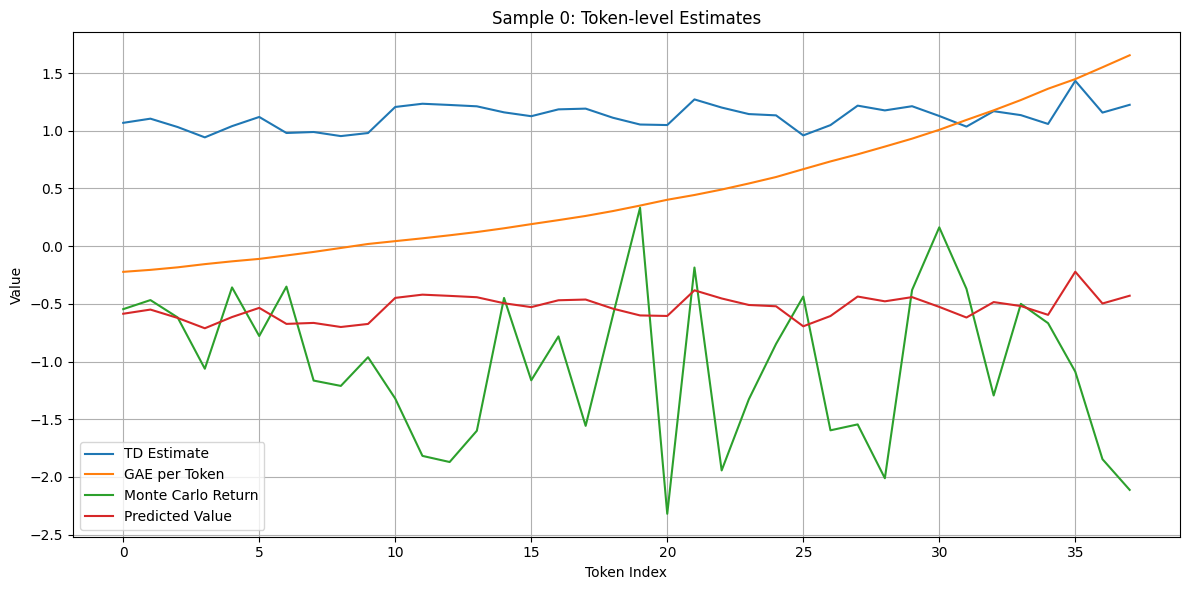

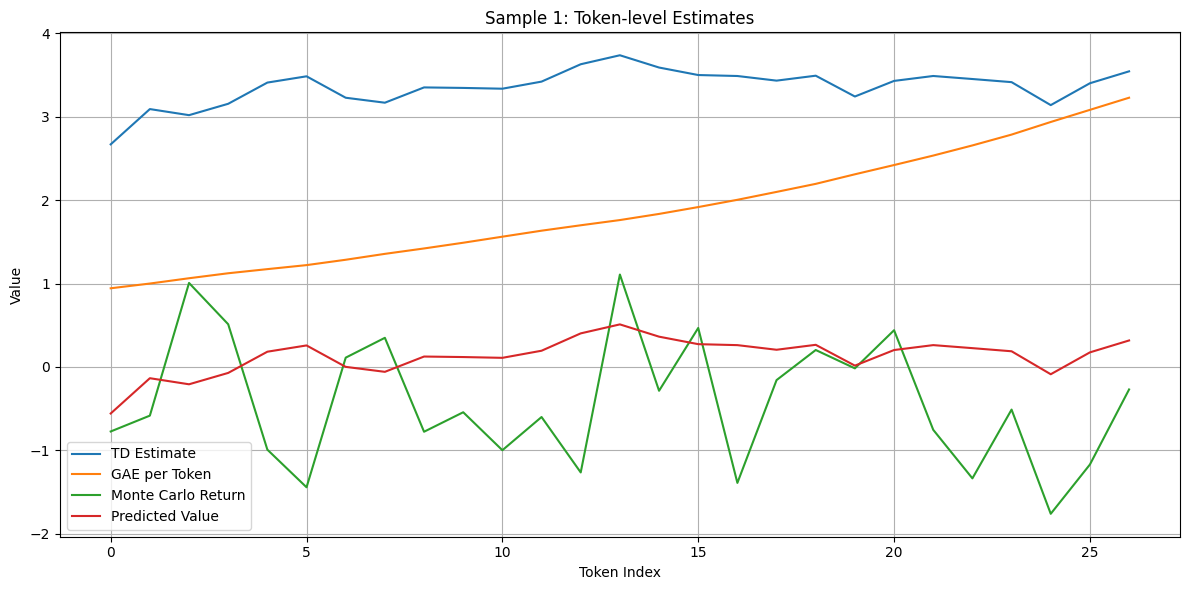

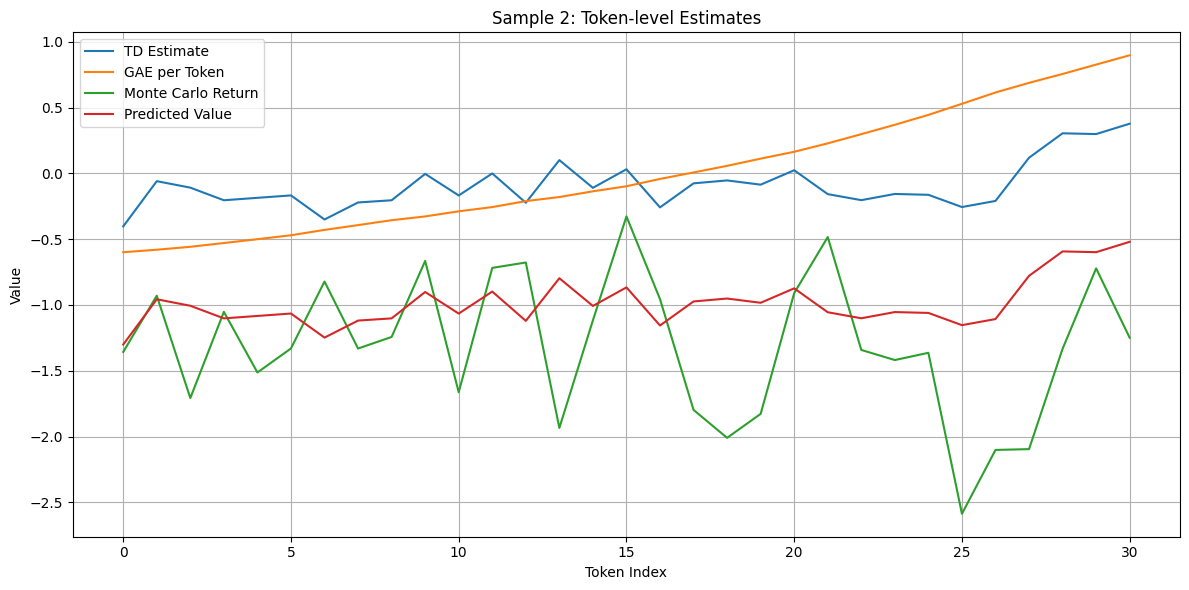

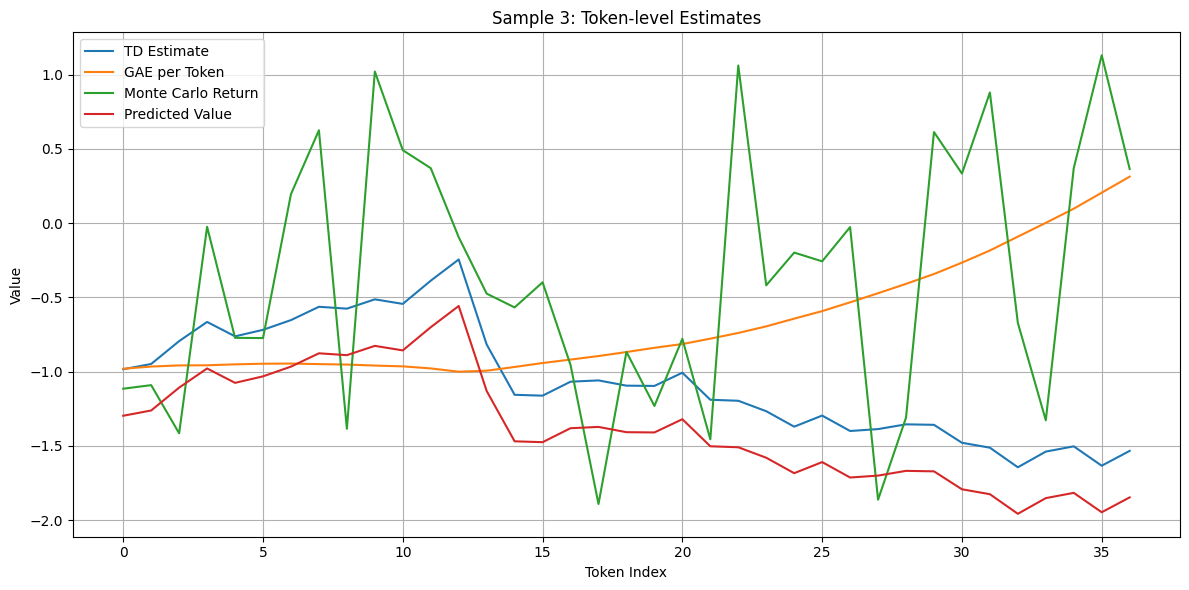

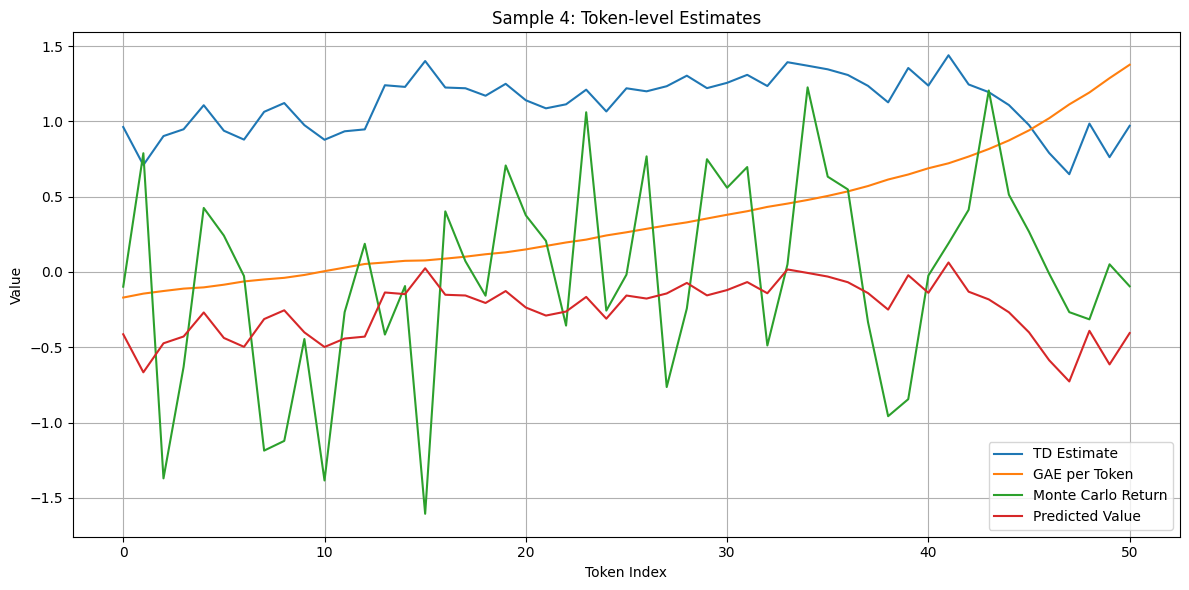

In [91]:
import matplotlib.pyplot as plt

for idx, row in result_df.iterrows():
    plt.figure(figsize=(12, 6))
    
    seq_len = row["response_token_len"]
    x = list(range(seq_len))
    
    plt.plot(x, row["td_estimate"], label="TD Estimate")
    plt.plot(x, row["gae_return"], label="GAE per Token")
    plt.plot(x, row["mc_per_token"], label="Monte Carlo Return")
    plt.plot(x, row["pred_value_per_token"], label="Predicted Value")
    
    plt.title(f"Sample {idx}: Token-level Estimates")
    plt.xlabel("Token Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()